# Part 7: Feature Filtering and Dimensionality Reduction

We examine the performance of a Logistic Regression and a Random Forest model on filtered features, as well as PCA-transformed features

We begin by importing all needed libraries. We will use pandas and arff from scipy.io to load and process our data.

We will also use sklearn to split our data, standardize, rank feature importance using the logistic regression and random forest classifiers, perform PCA and evaluate our models.

Matplotlib will be used for plotting and gaining insights.

The numpy and os modules will be used for miscellaneous operations.

In [1]:
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.io import arff
import pandas as pd
import os

## Data preparation

Our data is stored in the HTRU2 folder. Let's take a look at its contents.

In [2]:
data_dir = 'HTRU2/'
os.listdir(data_dir)

['HTRU_2.arff', 'HTRU_2.csv', 'Readme.txt']

The Readme file contains some useful information for our dataset and is worth reading.

In [3]:
with open(data_dir + 'Readme.txt') as f:
    print(f.read())

******************************************************************************************

# HTRU2

Author: Rob Lyon, School of Computer Science & Jodrell Bank Centre for Astrophysics,
		University of Manchester, Kilburn Building, Oxford Road, Manchester M13 9PL.

Contact:	rob@scienceguyrob.com or robert.lyon@.manchester.ac.uk
Web:		http://www.scienceguyrob.com or http://www.cs.manchester.ac.uk
			or alternatively http://www.jb.man.ac.uk
******************************************************************************************

1. Overview

	HTRU2 is a data set which describes a sample of pulsar candidates collected during the
	High Time Resolution Universe Survey (South) [1]. 
	
	Pulsars are a rare type of Neutron star that produce radio emission detectable here on
	Earth. They are of considerable scientific interest as probes of space-time, the inter-
	stellar medium, and states of matter (see [2] for more uses). 
	
	As pulsars rotate, their emission beam sweeps across the sky, and 

This time, we will load our data using an arff file. The arff file in this case contains a bit more information and can help with the automatic labeling of our dataset columns.

In [4]:
data = arff.loadarff(data_dir + 'HTRU_2.arff')
htru2_df = pd.DataFrame(data[0])
htru2_df

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225,b'0'
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580,b'0'
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909,b'0'
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661,b'0'
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306,b'0'
...,...,...,...,...,...,...,...,...,...
17893,136.429688,59.847421,-0.187846,-0.738123,1.296823,12.166062,15.450260,285.931022,b'0'
17894,122.554688,49.485605,0.127978,0.323061,16.409699,44.626893,2.945244,8.297092,b'0'
17895,119.335938,59.935939,0.159363,-0.743025,21.430602,58.872000,2.499517,4.595173,b'0'
17896,114.507812,53.902400,0.201161,-0.024789,1.946488,13.381731,10.007967,134.238910,b'0'


We convert the class column into integer values to use as our targets.

In [5]:
htru2_df['class'] = htru2_df['class'].astype(int)

Let's take a look at some dataset information.

In [6]:
htru2_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Profile_mean      17898 non-null  float64
 1   Profile_stdev     17898 non-null  float64
 2   Profile_skewness  17898 non-null  float64
 3   Profile_kurtosis  17898 non-null  float64
 4   DM_mean           17898 non-null  float64
 5   DM_stdev          17898 non-null  float64
 6   DM_skewness       17898 non-null  float64
 7   DM_kurtosis       17898 non-null  float64
 8   class             17898 non-null  int32  
dtypes: float64(8), int32(1)
memory usage: 1.2 MB


In [7]:
htru2_df.describe()

,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
count,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000,17898.000000
mean,111.079968,46.549532,0.477857,1.770279,12.614400,26.326515,8.303556,104.857709,0.091574
std,25.652935,6.843189,1.064040,6.167913,29.472897,19.470572,4.506092,106.514540,0.288432
min,5.812500,24.772042,-1.876011,-1.791886,0.213211,7.370432,-3.139270,-1.976976,0.000000
25%,100.929688,42.376018,0.027098,-0.188572,1.923077,14.437332,5.781506,34.960504,0.000000
50%,115.078125,46.947479,0.223240,0.198710,2.801839,18.461316,8.433515,83.064556,0.000000
75%,127.085938,51.023202,0.473325,0.927783,5.464256,28.428104,10.702959,139.309330,0.000000
max,192.617188,98.778911,8.069522,68.101622,223.392141,110.642211,34.539844,1191.000837,1.000000


## Training

In this section, we will train a logistic regression and a random forest classifier.

Our goal is to examine differences with plain features and by applying PCA, extract feature importance by examining our classifiers, rank those features, and use the top 4 features as a next step in classification.

### Without PCA

We begin by standardizing our features, an important step when PCA is involved.
We also extract targets.

In [8]:
features = StandardScaler().fit_transform(htru2_df.drop(columns='class'))
targets = htru2_df['class']

We split our data.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(features, targets, stratify=targets)

#### Logistic regression

And start with the logistic regression classifier.

In [10]:
lr_clf = LogisticRegression().fit(x_train, y_train)

We predict labels

In [11]:
y_predicted = lr_clf.predict(x_test)

And evaluate

In [12]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.9783240223463687
Precision: 0.9335180055401662
Recall: 0.8219512195121951
F1: 0.8741893644617379


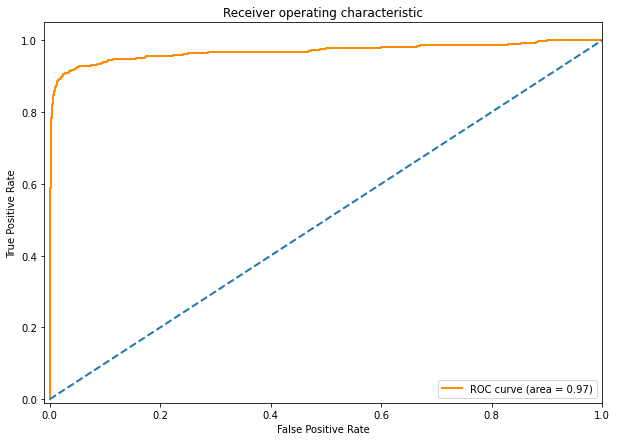

In [13]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

Let's now take a look at the most important features, based on our classifier.

In [14]:
lr_clf.coef_

array([[ 0.40518678, -0.11764762,  5.9863921 , -3.03508912, -0.81498129,
         1.00907673,  0.29264419, -0.78608814]])

Profile skewness, profile kurtosis and DM standard deviation and mean seem to be ranked the highest.

In [15]:
lr_feat_importance = {x[0]: x[1] for x in 
 sorted(
     zip(htru2_df.columns, np.abs(lr_clf.coef_[0])), 
     key= lambda x: x[1], 
     reverse=True
 )
}
lr_feat_importance

{'Profile_skewness': 5.986392099414634,
 'Profile_kurtosis': 3.035089116286893,
 'DM_stdev': 1.009076730773693,
 'DM_mean': 0.8149812858127462,
 'DM_kurtosis': 0.7860881365256552,
 'Profile_mean': 0.4051867811407669,
 'DM_skewness': 0.2926441926096504,
 'Profile_stdev': 0.11764761567633004}

#### Random Forest

We perform the same procedure with a random forest classifier.

In [16]:
rf_clf = RandomForestClassifier().fit(x_train, y_train)

In [17]:
y_predicted = rf_clf.predict(x_test)

In [18]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.980782122905028
Precision: 0.9378378378378378
Recall: 0.8463414634146341
F1: 0.8897435897435898


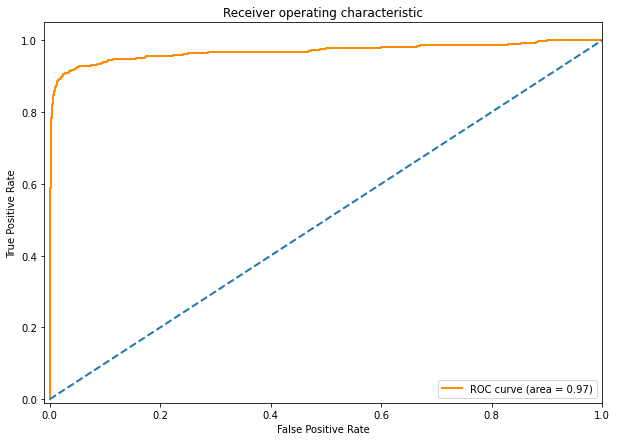

In [19]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

In [20]:
rf_clf.feature_importances_

array([0.12075666, 0.05751439, 0.36097481, 0.22930101, 0.06962814,
       0.07281098, 0.05000377, 0.03901025])

In [21]:
rf_feat_importance = {x[0]: x[1] for x in 
 sorted(
     zip(htru2_df.columns, np.abs(rf_clf.feature_importances_)), 
     key= lambda x: x[1], 
     reverse=True
 )
}
rf_feat_importance

{'Profile_skewness': 0.36097480526468206,
 'Profile_kurtosis': 0.22930100984937796,
 'Profile_mean': 0.1207566605772503,
 'DM_stdev': 0.07281098338771101,
 'DM_mean': 0.06962814170481371,
 'Profile_stdev': 0.05751438553668825,
 'DM_skewness': 0.05000376825375834,
 'DM_kurtosis': 0.03901024542571838}

### With PCA

Now we want to examine model performance using PCA instead of our original features.
We perform a similar procedure.

In [22]:
pca_features = PCA(n_components=4).fit_transform(features)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(pca_features, targets, stratify=targets)

#### Logistic regression

In [24]:
lr_clf = LogisticRegression().fit(x_train, y_train)

In [25]:
y_predicted = lr_clf.predict(x_test)

In [26]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.9776536312849162
Precision: 0.9479768786127167
Recall: 0.8
F1: 0.8677248677248678


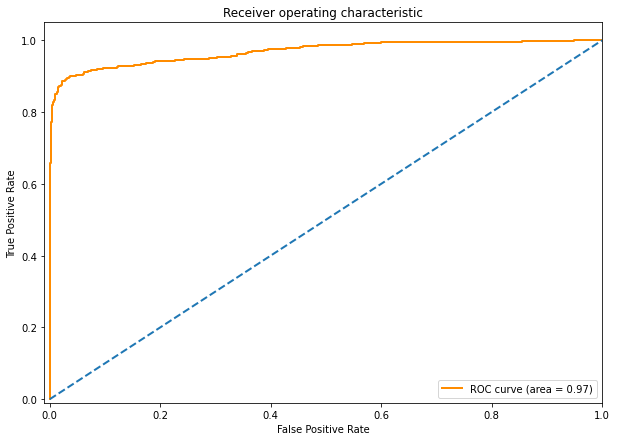

In [27]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

#### Random Forest

In [28]:
rf_clf = RandomForestClassifier().fit(x_train, y_train)

In [29]:
y_predicted = rf_clf.predict(x_test)

In [30]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.9774301675977654
Precision: 0.9164420485175202
Recall: 0.8292682926829268
F1: 0.8706786171574905


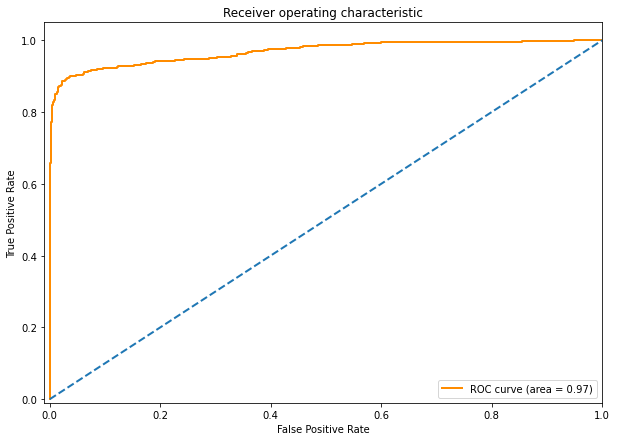

In [31]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

### Using most important features

We will now take the top 4 features, as they were ranked by our classifiers.

We will once again examine all cases, using ranked features from both classifiers, and using them with both logistic regression and random forest models.

#### Based on logistic regression

In [32]:
column_idx = [htru2_df.columns.get_loc(c) for c in list(lr_feat_importance.keys())[:4]]

In [33]:
top4_lr_features = features[:, column_idx]

In [34]:
x_train, x_test, y_train, y_test = train_test_split(top4_lr_features, targets, stratify=targets)

##### Logistic regression classifier

In [35]:
lr_clf = LogisticRegression().fit(x_train, y_train)

In [36]:
y_predicted = lr_clf.predict(x_test)

In [37]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.9794413407821229
Precision: 0.9274193548387096
Recall: 0.8414634146341463
F1: 0.8823529411764706


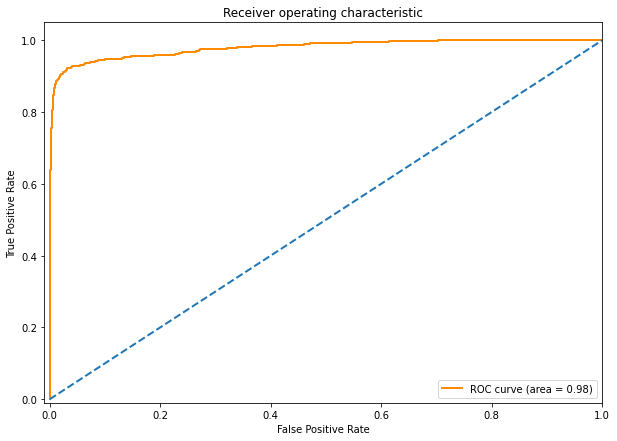

In [38]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

##### Random Forest classifier

In [39]:
rf_clf = RandomForestClassifier().fit(x_train, y_train)

In [40]:
y_predicted = rf_clf.predict(x_test)

In [41]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.9801117318435755
Precision: 0.9147286821705426
Recall: 0.8634146341463415
F1: 0.8883312421580929


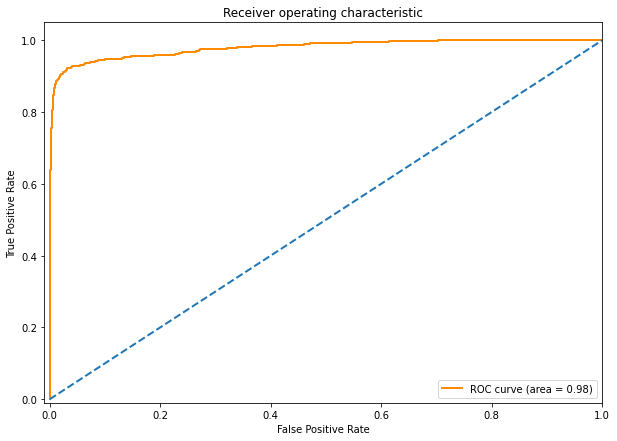

In [42]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

#### Based on random forest

In [43]:
column_idx = [htru2_df.columns.get_loc(c) for c in list(rf_feat_importance.keys())[:4]]

In [44]:
top4_lr_features = features[:, column_idx]

In [45]:
x_train, x_test, y_train, y_test = train_test_split(top4_lr_features, targets, stratify=targets)

##### Logistic regression classifier

In [46]:
lr_clf = LogisticRegression().fit(x_train, y_train)

In [47]:
y_predicted = lr_clf.predict(x_test)

In [48]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.9803351955307262
Precision: 0.9573863636363636
Recall: 0.8219512195121951
F1: 0.884514435695538


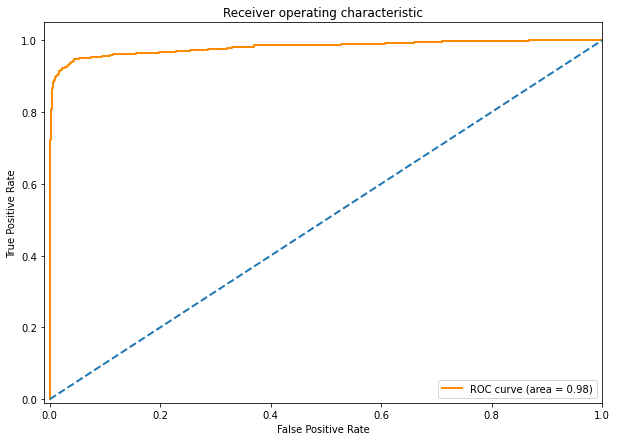

In [49]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

##### Random Forest classifier

In [50]:
 rf_clf = RandomForestClassifier().fit(x_train, y_train)

In [51]:
y_predicted = rf_clf.predict(x_test)

In [52]:
print('Accuracy:', metrics.accuracy_score(y_test, y_predicted))
print('Precision:', metrics.precision_score(y_test, y_predicted))
print('Recall:', metrics.recall_score(y_test, y_predicted))
print('F1:', metrics.f1_score(y_test, y_predicted))

Accuracy: 0.9812290502793296
Precision: 0.9335106382978723
Recall: 0.8560975609756097
F1: 0.8931297709923665


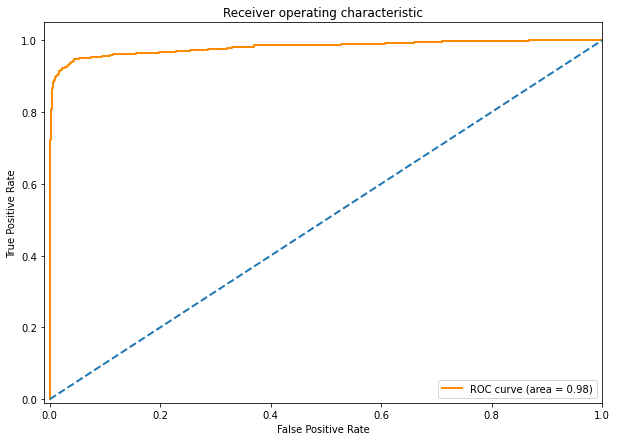

In [53]:
fpr, tpr, _ = metrics.roc_curve(y_test, lr_clf.decision_function(x_test))
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10,7))
plt.plot(fpr, tpr ,color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc='lower right');

When comparing the performance of the algorithms with different features, the top 4 features ranked by logistic regression performed the best. Regular features follow, with the top 4 features ranked by random forest coming next and PCA features coming last.

All features performed almost equally, with the exception of PCA, which produced the most noticeably worse results overall.